# 图像细粒度分类

Inception、Xception、NASNetLarge、InceptionRes in Tensorflow2

Kaggle Competition:Dog Breed Identification

https://www.kaggle.com/atrisaxena/using-tensorflow-2-x-to-classify-breeds-of-dogs

In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [29]:
base_path = 'D:\Code\Exercise\dog-breed'

# 数据集处理

数据主要结构是训练集图像放在训练集文件夹里面，标签以csv格式的数据记录

In [30]:
# 读取标签
label_path = os.path.join(base_path, 'labels.csv')
labels = pd.read_csv(label_path)
print(labels.head())
print(labels.describe())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     56d91388512400bf079a9663dd0b5ad5  scottish_deerhound
freq                                   1                 126


In [31]:
# 查看数据的格式
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))

#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [32]:
# 设置成331的原因是NASNetLarge默认的输入shape大小是(331, 331, 3)
img_size = (331, 331, 3)

def images_to_array(directory, label_dataframe, target_size = img_size):
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8)
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    for ix, image_name in enumerate(label_dataframe['id'].values):
        img_dir = os.path.join(directory, image_name+'.jpg')
        img = load_img(img_dir, target_size=target_size)
        images[ix]=img
        del img

        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    y = to_categorical(y)
    return images, y

In [33]:
import time 
t = time.time()
image_path = os.path.join(base_path, 'train')
X,y = images_to_array(image_path, labels[:])
print('runtime in seconds: {}'.format(time.time() - t))

runtime in seconds: 13.001343250274658


In [34]:
img_size = (331, 331, 3)
def images_to_array(directory, label_dataframe):
    image_labels = label_dataframe['breed']
    images = label_dataframe['id']
    # images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8)
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    for ix, image_name in enumerate(label_dataframe['id'].values):
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    y = to_categorical(y)
    filenames = [os.path.join(directory, img+'.jpg') for img in label_dataframe['id'] ]
    return filenames, y

In [57]:
batch_size= 128

def preprocess_img(image_path, image_size): 
    """
    This function will read image, resize the image and return into TF format. 
    Arguments: 
        image_path(str): Path of image
    Returns: 
        img: Tensor image
    """
    img = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    img = tf.io.decode_image(img, channels =3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to our desired size (224, 244)
    img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)
    return img

def load_image(img_path, label):
    img = preprocess_img(img_path, image_size=img_size[0])
    return img, label

BATCH_SIZE = 32 

#Create function to create dataset batches 
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data=False): 
    """
    This function will help to accept Train Images (X) and labels (y). 
    Also Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """
    if test_data: 
        print("Creating Test data")
        test_data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        test_data = test_data.map(load_image).batch(BATCH_SIZE) 
        return test_data 
    
    #Create validation data
    if valid_data: 
        print("Creating Validation data")
        valid_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        valid_data = valid_data.map(load_image).batch(BATCH_SIZE)
        return valid_data
    
    #Shuffle and create training data
    else: 
        print("Creating Training Data") 
        train_data = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(buffer_size = len(X))
        train_data = train_data.map(load_image).batch(BATCH_SIZE) 
        return train_data 


In [58]:
X_train, Y_train = images_to_array(image_path, labels[:])
# train_data = tf.data.Dataset.from_tensor_slices((X_train,Y_train)).shuffle(buffer_size = len(X_train))
# img = preprocess_img(X_train[0], img_size)
# img.show()
train_data = create_data_batches(X_train, Y_train)
print(type(train_data))

Creating Training Data
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [66]:
# Batch形式展示数据
import matplotlib.pyplot as plt 
num_to_class = {v : k for k, v in class_to_num.items()}
def show_images(images, label): 
    """
    Display 25 Images with labels. 
    """
    #Setup the figure 
    plt.figure(figsize = (12,12)) 
    for i in range(0,25): 
        ax = plt.subplot(5, 5, i+1)
        
        plt.imshow(images[i])
        
        plt.title(num_to_class[np.argmax(label[i])])
        
        plt.axis("off")

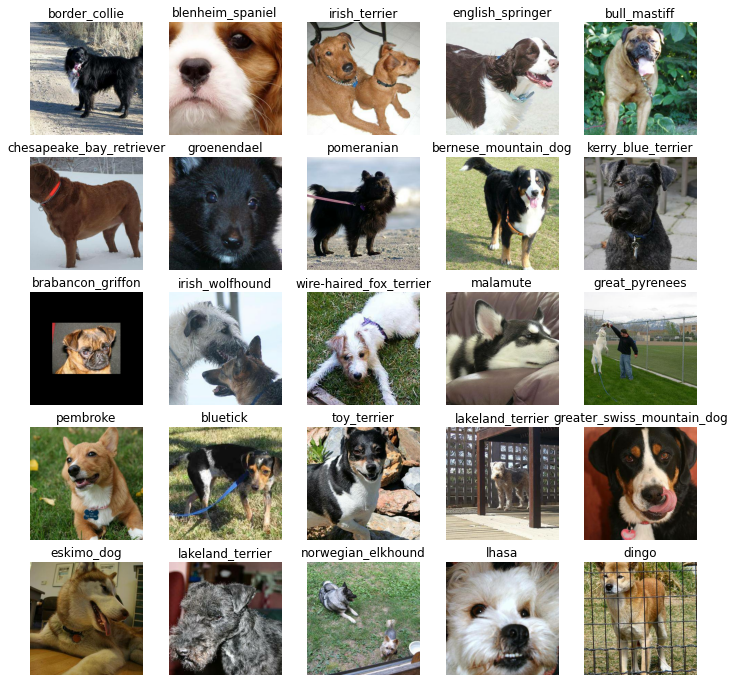

In [68]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

In [ ]:
# 展示数据
import matplotlib.pyplot as plt
n=25
plt.figure(figsize=(20,20))

for i in range(n):
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) 

## 建立模型
建立Inception、Xception、NASNetLarge, InceptionRes

In [ ]:

def get_feature(model_name, model_preprocessor, input_size, data):
    input_layer = Input(img_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape = input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    # Extract feature
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [ ]:
# Extract featurs using InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_feature(InceptionV3, inception_preprocessor, img_size, X)

In [ ]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_feature(Xception,
                                 xception_preprocessor,
                                 img_size, X)

In [ ]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_feature(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

In [ ]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_feature(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

In [ ]:
# Hyperparameters
epochs=50
learn_rate=.001
sgd=tf.keras.optimizers.SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam= tf.keras.optimizers.Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [ ]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                #  nasnet_features,
                                 inc_resnet_features], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

In [ ]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

# 测试模型

In [ ]:
img_g = load_img('./dog-breed/train/0a0c223352985ec154fd604d7ddceabd.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0)

In [ ]:
# #Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")